In [203]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import seaborn as  sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [204]:
df_train = pd.read_csv("https://raw.githubusercontent.com/HMateika/NWDataPrep-ManagementAssignment1/main/HP_train.csv")
df_test = pd.read_csv("https://raw.githubusercontent.com/HMateika/NWDataPrep-ManagementAssignment1/main/HP_test.csv")

### My first task involved figuring out which variables were the most correlated with the housing sales price. Looking below you can see that I implemented a heat map for visual purposes.

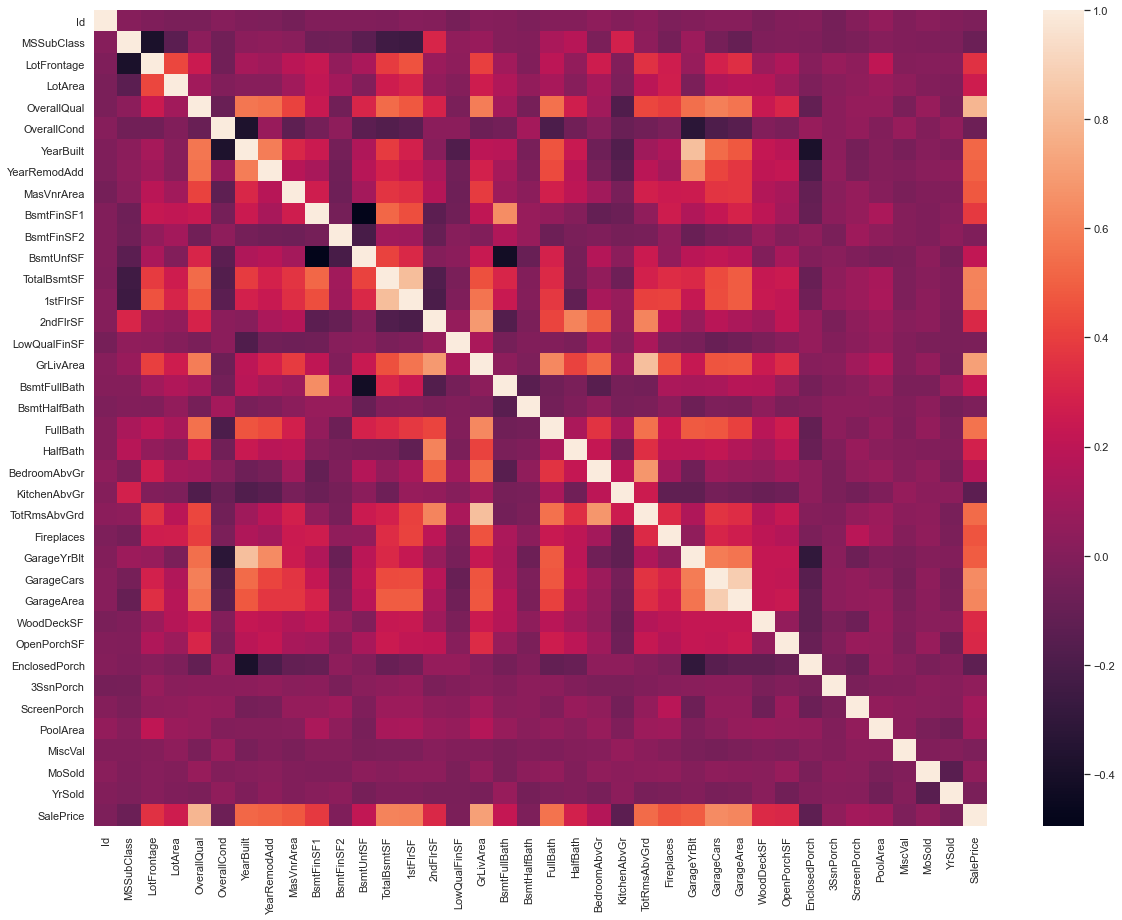

In [205]:
sns.set(rc={'figure.figsize':(20,15)})
sns.heatmap(df_train.corr());

### Looking at the heatmap toward the bottom, I felt that a positive correlation over .5 was the most appropriate in terms of limiting the continuous variables that I worked with.

In [206]:
correlation_dataframe = df_train.corr()
predictors = correlation_dataframe["SalePrice"][(correlation_dataframe["SalePrice"]> .5)]

In [207]:
predictors = list(predictors.index)
predictive_df = df_train[predictors]

## Feature Manipulation for continuous variables

### Looking at the head below I saw that there were multiple instances where some of the variables seemed to feed in together. For instance, the first floor square footage definitely has an impact on the Above ground living area.

In [208]:
predictive_df.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,7,2003,2003,856,856,1710,2,8,2,548,208500
1,6,1976,1976,1262,1262,1262,2,6,2,460,181500
2,7,2001,2002,920,920,1786,2,6,2,608,223500
3,7,1915,1970,756,961,1717,1,7,3,642,140000
4,8,2000,2000,1145,1145,2198,2,9,3,836,250000


### Taking in the work that I did last time. I decided to combine all of the appropriate square foot variables into one while dropping the first floor square feet. This is ultimately going to have the model presume that total square footage has more value than first floor square footage. However, given the results of the last assignment, I was willing to take the particular chance.

In [209]:
predictive_df["Squarefoot"] = predictive_df["TotalBsmtSF"] + predictive_df["GrLivArea"] + predictive_df["GarageArea"]
SalePrice = predictive_df["SalePrice"]
predictive_df = predictive_df.drop(columns = ["TotalBsmtSF", "GrLivArea", "GarageArea", "1stFlrSF", "SalePrice"])
predictive_df

<ipython-input-209-e3f468e07eb7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictive_df["Squarefoot"] = predictive_df["TotalBsmtSF"] + predictive_df["GrLivArea"] + predictive_df["GarageArea"]


,OverallQual,YearBuilt,YearRemodAdd,FullBath,TotRmsAbvGrd,GarageCars,Squarefoot
0,7,2003,2003,2,8,2,3114
1,6,1976,1976,2,6,2,2984
2,7,2001,2002,2,6,2,3314
3,7,1915,1970,1,7,3,3115
4,8,2000,2000,2,9,3,4179
...,...,...,...,...,...,...,...
1455,6,1999,2000,2,7,2,3060
1456,6,1978,1988,2,7,2,4115
1457,7,1941,2006,2,9,1,3744
1458,5,1950,1996,1,5,1,2396


### I then decided to check for the collinearity of independent variables.

In [210]:
predictive_df.corr()

,OverallQual,YearBuilt,YearRemodAdd,FullBath,TotRmsAbvGrd,GarageCars,Squarefoot
OverallQual,1.000000,0.572323,0.550684,0.550600,0.427452,0.600671,0.695875
YearBuilt,0.572323,1.000000,0.592855,0.468271,0.095589,0.537850,0.394681
YearRemodAdd,0.550684,0.592855,1.000000,0.439046,0.191740,0.420622,0.373263
FullBath,0.550600,0.468271,0.439046,1.000000,0.554784,0.469672,0.583417
TotRmsAbvGrd,0.427452,0.095589,0.191740,0.554784,1.000000,0.362289,0.657911
GarageCars,0.600671,0.537850,0.420622,0.469672,0.362289,1.000000,0.651213
Squarefoot,0.695875,0.394681,0.373263,0.583417,0.657911,0.651213,1.000000


### At this point I realized that there was some collinearity between Overall Quality and square footage. Furthermore overall quality also had high degrees of positive interaction with other variables as well. Futhermore, overall quality isn't informative. It is fairly common sense that a high Overall Quality rating would increase the valeu of the home. For those reasons I decided that it would be appropriate to drop the variable. 

In [211]:
predictive_df = predictive_df.drop(columns = ["OverallQual"])

### I decided to add another variable by measuring the difference in years between the year sold and the year remodeled. I thought that variable would be more helpful in comparison to the year it was remodeled.

In [212]:
predictive_df["Years_Bet_Remodel_And_Sold"] = df_train["YrSold"]-df_train["YearRemodAdd"]
predictive_df = predictive_df.drop(columns = ["YearRemodAdd"])

In [213]:
predictive_df.corr()

,YearBuilt,FullBath,TotRmsAbvGrd,GarageCars,Squarefoot,Years_Bet_Remodel_And_Sold
YearBuilt,1.000000,0.468271,0.095589,0.537850,0.394681,-0.593868
FullBath,0.468271,1.000000,0.554784,0.469672,0.583417,-0.440413
TotRmsAbvGrd,0.095589,0.554784,1.000000,0.362289,0.657911,-0.194005
GarageCars,0.537850,0.469672,0.362289,1.000000,0.651213,-0.423236
Squarefoot,0.394681,0.583417,0.657911,0.651213,1.000000,-0.375469
Years_Bet_Remodel_And_Sold,-0.593868,-0.440413,-0.194005,-0.423236,-0.375469,1.000000


### Next I decided to pick a categorical variable. This choice was tricky but I decided that I wanted to figure out that if all else were equal, what would the impact on the neighborhood add to the price of the home. Therefore, I went with the Neighborhood variable and made dummy variables out of them.

In [214]:
categoricals = ["Neighborhood"]
df_neighborhood = pd.get_dummies(df_train[categoricals])


### I then implemented a Standard Scaler to scale back the continuous variables, then I joined them with the new categoricals dummy variables.

In [215]:
scaler = StandardScaler()

In [216]:
scale = scaler.fit_transform(predictive_df.to_numpy())
colname = list(predictive_df.columns.values)
scaled_df = pd.DataFrame(scale, columns = colname)
new_df = scaled_df.join(df_neighborhood)

## Regressions

### My main curiosity was about how these variables can correctly predict home prices. I started with a linear regression with a 5-fold cross validation process. The score indicated that these variables were relatively good predictors of sales price. What was interesting though was how the coefficients broke out. While some neighborhoods were not statistically significant, many of them were. Some of them (like Bloomington, Edwards, and Meadow Valley) definitely brought the price down while many of the other neighborhoods (Brookside, North Ridge, Stone Bridge) brought the price up. Some of these neighborhood coefficients, in fact, had a bigger impact than even the square footage of the house. However, one of my primary concerns is that the standard errors on these homes are ridiculously high in comparison to the more continuous variables.

In [217]:
#Linear Regression

model = LinearRegression()
mse_scores = cross_val_score(model, new_df, SalePrice, cv = 5)
print(mse_scores.mean())


x = sm.add_constant(new_df)
est = sm.OLS(SalePrice, x)
est2 = est.fit()
print(est2.summary())

0.7703418788887287
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     175.6
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:36:58   Log-Likelihood:                -17416.
No. Observations:                1460   AIC:                         3.489e+04
Df Residuals:                    1429   BIC:                         3.506e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
c

### I then decided to try adding a polynomial feature to see if it would bring the MSE down. This did not work and led to a far higher error rate.

In [218]:
#Polynomial (with everything)
model_2 = PolynomialFeatures(degree=2)
x_poly = model_2.fit_transform(new_df)
mse_scores = cross_val_score(model, x_poly, SalePrice, cv = 5)
print(mse_scores.mean())

-1.7681847522964689e+19


### While these factors were helpful in generating an overall prediction. Having something to present to management usually requires something more simplistic. For that reason, I decided it would likely be best to pick a variable that is directly measurable against sales price to perform singular regression on. For that reason I decided to pick only square footage to measure. The reason is that it has the highest continuous coefficient and its standard error is far fewer than the amount applied to neighborhoods.

### The first scatterplot below is not particularly helpful since there are two extreme outliers. In an effort to make the model more consistent I decided to remove them (although there was a chance I could have run a polynomial degree that would have matched this, but I think that would have been at the risk of alienating the more clustered variables.)

C:\Users\harrisonm\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


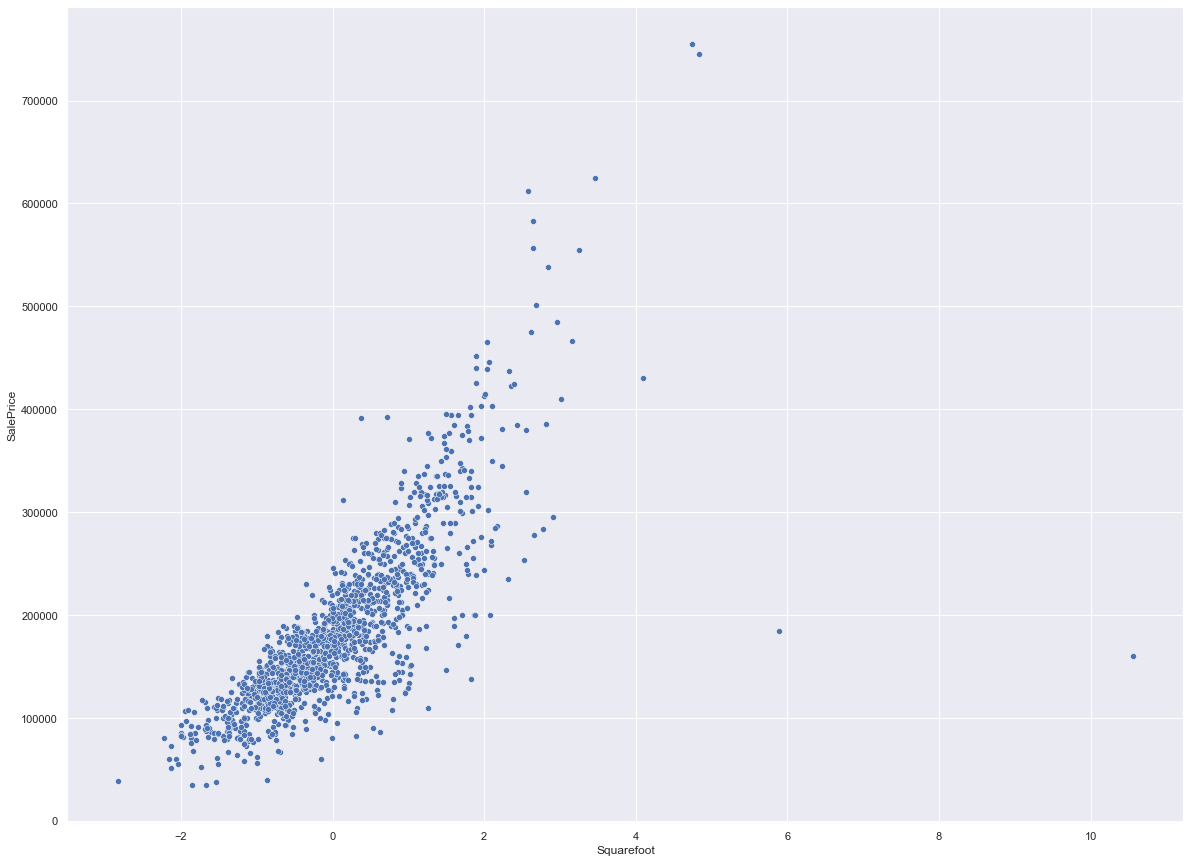

In [219]:
sns.scatterplot(new_df["Squarefoot"], SalePrice);

### The final curve below is interesting. It definitely can be well predicted linearly, but it could also be predicted pretty well with a 2nd degree polynomial.

C:\Users\harrisonm\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


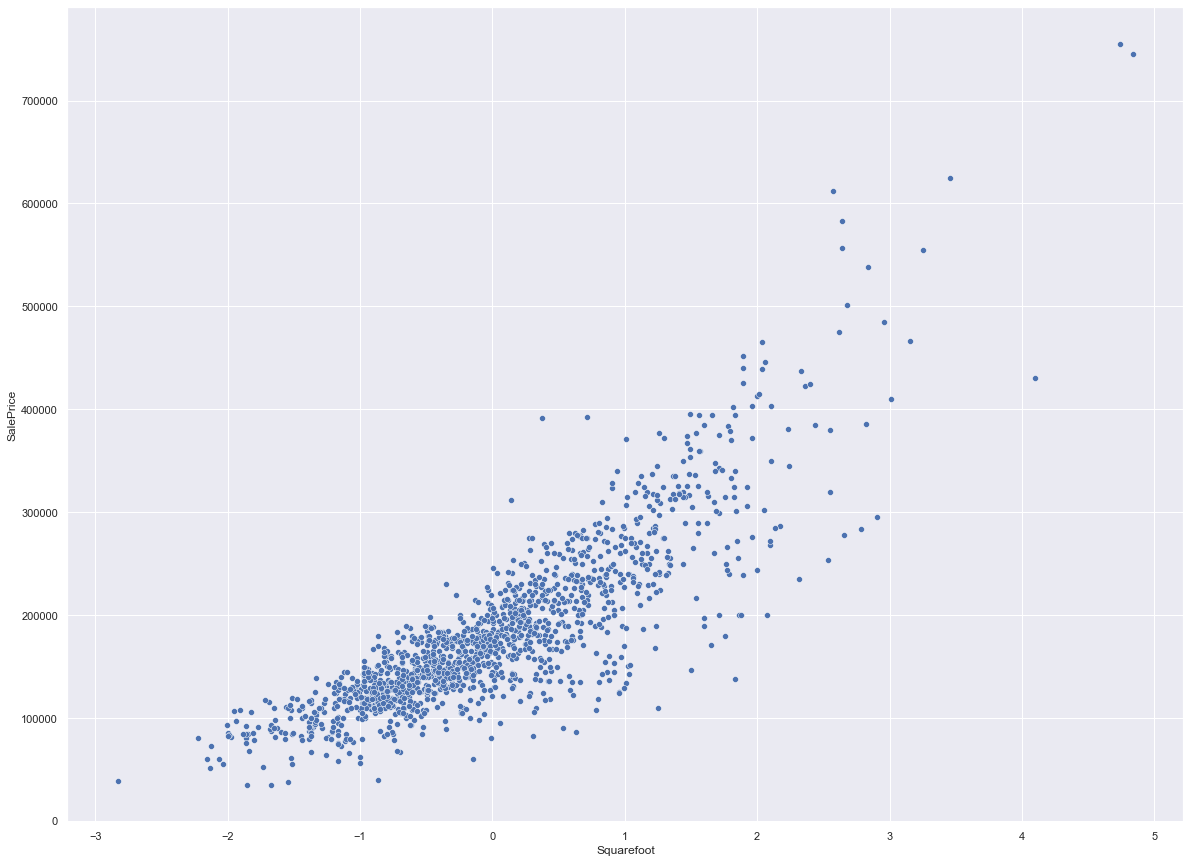

In [220]:
final_df = new_df.join(SalePrice)
final_df = final_df[final_df["Squarefoot"] <= 5.5]
sns.scatterplot(final_df["Squarefoot"], final_df["SalePrice"]);

In [221]:
squarefoot = final_df["Squarefoot"]
saleprice = final_df["SalePrice"]
t = np.asarray(squarefoot)
x = t.reshape(-1,1)
t = np.asarray(saleprice)
y = t.reshape(-1,1)
x.shape, y.shape

((1458, 1), (1458, 1))

### For my first regression analysis I utilized the SciKitLearn cross-validation score method to get my MSE while using the train_test_split function to get my R-Squared score. The error rate is pretty good, but the R-Squared leave something to be desired.

In [222]:
#Linear Regression
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 3) 
model = LinearRegression()
mse_score = cross_val_score(model, x, y, cv = 5).mean()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
r_square = r2_score(predictions, y_test)
print(mse_score)
print(r_square)

0.7228111423776001
0.6047509489525169


### The second polynomial model performs a lot better. The MSE is comparable to the above multiple regression model. While the R-Squared is lower, it could potentially be attributed to the amount of variables in the multiple regression model rather than its lack of performance. Altogether, I believe this is a solid basis to go on for management that the larger a house is, the more likely it is that the sale price is better even in times when all else is equal. It would be worth moving a step further in the future to account for all quality related variables to see what difference it makes.

In [223]:
model_2 = PolynomialFeatures(degree=2)
x_poly = model_2.fit_transform(x)
mse_scores = cross_val_score(model, x_poly, y, cv = 5)
poly_train = model_2.fit_transform(x_train)
poly_test = model_2.fit_transform(x_test)
model.fit(poly_train, y_train)
predictions = model.predict(poly_test)
r_square = r2_score(predictions, y_test)
print(mse_scores.mean())
print(r_square)

0.7510209981888553
0.6519900957255577


## This model is not perfect. The main assumption that it makes is that square footage is the best predictor while almost everything else has less of an impact. However, it shows to management just how primary the amount of space is regarding the price of a house. It's a good model primarily because it has an error rate on par with the regression model that takes in other factors above, so it's safe to say that the size of the house will mostly correctly predict the sales price. If I were to take recommendations a step further for management I would delve in more to how quality affects the sales price when paired with square footage. Perhaps this would be a solid future project. In terms of why management would care though is that perhaps if they developed or sold more properties with large square footage in less than ideal neighborhoods they can make a significant profit since those areas likely have less competition.   

## Kaggle Submission

In [224]:
df_test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [225]:
df_test["Squarefoot"] = df_test["TotalBsmtSF"] + df_test["GrLivArea"] + df_test["GarageArea"]
df_test["Squarefoot"] = df_test["Squarefoot"].fillna(0)

In [228]:
x_test = df_test["Squarefoot"]
x_test = np.asarray(x_test)
x_test = x_test.reshape(-1,1)
scale = scaler.fit_transform(x_test)
model.fit(poly_train, y_train)
scale = model_2.fit_transform(scale)
predictions = model.predict(scale)
print(predictions)

[[141259.62108554]
 [170926.22832971]
 [175761.17360827]
 ...
 [174701.16225687]
 [108576.08504597]
 [222821.64821384]]


In [238]:
predictions = predictions.flatten()

[141259.62108554 170926.22832971 175761.17360827 ... 174701.16225687
 108576.08504597 222821.64821384]


In [239]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)